In [7]:
!pip install nltk
!pip install transformers
!pip install razdel
!pip install scikit-learn
!pip install natasha

In [2]:
import pandas as pd
import torch
import seaborn as sns
import re

 # Посмотрим на предоставленные датасеты

In [3]:
train = pd.read_csv('../data/first_task/train.csv', encoding='utf-8')
test = pd.read_csv('../data/first_task/test.csv')
sample = pd.read_csv('../data/first_task/sample_submission.csv')

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189891 entries, 0 to 189890
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ID         189891 non-null  int64 
 1   text       189891 non-null  object
 2   sentiment  189891 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.3+ MB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21098 entries, 0 to 21097
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      21098 non-null  int64 
 1   text    21098 non-null  object
dtypes: int64(1), object(1)
memory usage: 329.8+ KB


In [12]:
sample

,ID,sentiment
0,0,0
1,1,2
2,2,2
3,3,2
4,4,1
...,...,...
21093,21093,0
21094,21094,0
21095,21095,0
21096,21096,0


In [13]:
train.isnull().any().any()

False

<Axes: xlabel='sentiment', ylabel='count'>

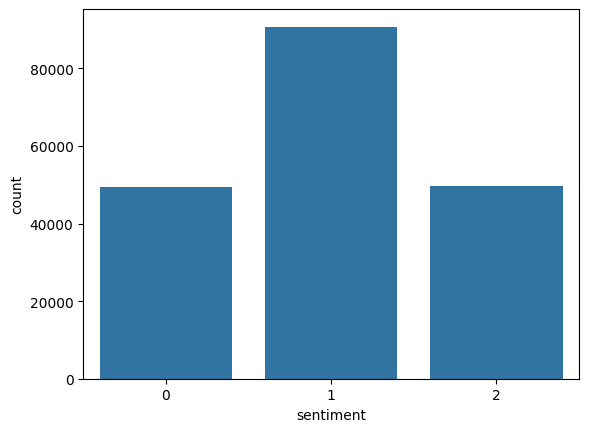

In [14]:
sns.countplot(x='sentiment', data=train)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Важный этап - предобработка текстовых данных

In [4]:
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

stop_words = set(stopwords.words('russian'))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antontagiev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Токенизируем текст и удалим знаки препинания и ссылки, чтобы не подавать в модель лишний шум

In [5]:
import razdel
import re


# Функция для токенизации текста с использованием библиотеки razdel
def tokenize_text(text):
    tokens = [token.text for token in razdel.tokenize(text)]
    return tokens


pattern = r'[^\w\s]|\d|http\S+'

# Применяем регулярное выражение ко всему столбцу 'Text'
train['text'] = train['text'].apply(lambda x: re.sub(pattern, '', x))
train['text'] = train['text'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))
# Применяем токенизацию сначала к тексту, а затем к результатам первой токенизации
train['refact_text'] = train['text'].apply(lambda tokens: ''.join(tokens))  # объединяем списки токенов обратно в текст
train['refact_text'] = train['refact_text'].apply(tokenize_text)  # применяем токенизацию с использованием razdel


In [6]:
train['refact_text'] = train['refact_text'].apply(lambda x: ' '.join(x))

In [7]:
train['refact_text']

0         си спросил его о Посланник АллахаТы порицаешь ...
1         Роднее всех родных Попала я в ГКБ еще в декабр...
2         Непорядочное отношение к своим работникам Рабо...
3         Отсутствуют нормативы Госты и прочее что позво...
4         У меня машина в руках лет и это первая моя маш...
                                ...                        
189886    Мой юбилей я отмечал в ресторане Астория Этот ...
189887    Отлично встретили разместили в роскошном номер...
189888    Была в Васаби на ст метро Сенная Во первых рес...
189889    Ребята не стоит смотреть этот фильм Вы молодые...
189890    Про махание руками нигде не нашел Почему сегод...
Name: refact_text, Length: 189891, dtype: object

In [25]:
stop_words

{'а',
 'без',
 'более',
 'больше',
 'будет',
 'будто',
 'бы',
 'был',
 'была',
 'были',
 'было',
 'быть',
 'в',
 'вам',
 'вас',
 'вдруг',
 'ведь',
 'во',
 'вот',
 'впрочем',
 'все',
 'всегда',
 'всего',
 'всех',
 'всю',
 'вы',
 'где',
 'да',
 'даже',
 'два',
 'для',
 'до',
 'другой',
 'его',
 'ее',
 'ей',
 'ему',
 'если',
 'есть',
 'еще',
 'ж',
 'же',
 'за',
 'зачем',
 'здесь',
 'и',
 'из',
 'или',
 'им',
 'иногда',
 'их',
 'к',
 'как',
 'какая',
 'какой',
 'когда',
 'конечно',
 'кто',
 'куда',
 'ли',
 'лучше',
 'между',
 'меня',
 'мне',
 'много',
 'может',
 'можно',
 'мой',
 'моя',
 'мы',
 'на',
 'над',
 'надо',
 'наконец',
 'нас',
 'не',
 'него',
 'нее',
 'ней',
 'нельзя',
 'нет',
 'ни',
 'нибудь',
 'никогда',
 'ним',
 'них',
 'ничего',
 'но',
 'ну',
 'о',
 'об',
 'один',
 'он',
 'она',
 'они',
 'опять',
 'от',
 'перед',
 'по',
 'под',
 'после',
 'потом',
 'потому',
 'почти',
 'при',
 'про',
 'раз',
 'разве',
 'с',
 'сам',
 'свою',
 'себе',
 'себя',
 'сейчас',
 'со',
 'совсем',
 'так

Аналогично удалим стоп-слова и приведем текст к нижнему регистру. Стоп-слова - слова, часто встречающиеся в языке и зачастую не несущие за собой много смысла, то есть зашумляющие модель

In [8]:
def remove_stopwords(text):
    words = text.split()  # Разбиваем текст на слова
    filtered_words = [word.lower() for word in words if
                      word.lower() not in stop_words]  # Фильтруем слова, игнорируя регистр
    return ' '.join(filtered_words)  # Собираем текст обратно


train['without_stopwords'] = train['refact_text'].apply(remove_stopwords)

In [9]:
train = train.drop('refact_text', axis=1)


In [37]:
train

,ID,text,sentiment,without_stopwords
0,21098,си спросил его о Посланник АллахаТы порицаешь ...,1,си спросил посланник аллахаты порицаешь чтото ...
1,21099,Роднее всех родных Попала я в ГКБ еще в декабр...,1,роднее родных попала гкб декабре г ехать больн...
2,21100,Непорядочное отношение к своим работникам Рабо...,2,непорядочное отношение своим работникам работа...
3,21101,Отсутствуют нормативы Госты и прочее что позво...,1,отсутствуют нормативы госты прочее позволило о...
4,21102,У меня машина в руках лет и это первая моя маш...,1,машина руках лет это первая машина могу никак ...
...,...,...,...,...
189886,210984,Мой юбилей я отмечал в ресторане Астория Этот ...,2,юбилей отмечал ресторане астория ресторан поль...
189887,210985,Отлично встретили разместили в роскошном номер...,1,отлично встретили разместили роскошном номере ...
189888,210986,Была в Васаби на ст метро Сенная Во первых рес...,0,васаби ст метро сенная первых ресторан оказалс...
189889,210987,Ребята не стоит смотреть этот фильм Вы молодые...,0,ребята стоит смотреть фильм молодые шутливые л...


## Лемматизация

In [ ]:
from pymystem3 import Mystem

mystem = Mystem()


def lemmatize_text(text):
    tokens = mystem.lemmatize(' '.join(text).lower())
    text = " ".join(tokens)
    return text


train['lem'] = train['without_stopwords'].apply(lemmatize_text)

In [ ]:
[text.split() for text in train['lem']][0]


In [ ]:
from gensim.models import FastText

sentences = [text.split() for text in train['lem']]

# Обучение модели FastText
model = FastText(sentences, window=5, min_count=1, workers=4, sg=1)



In [ ]:
# Пример применения модели для создания эмбеддингов для всех текстов в столбце
embeddings = []
for text in train['lem']:
    words = text.split()
    if words:
        # Средний вектор для всех слов в тексте
        avg_embedding = sum(model.wv[word] for word in words) / len(words)
    else:
        # Если список пуст, добавьте нулевой вектор
        avg_embedding = [0] * model.vector_size
    embeddings.append(avg_embedding)

# Добавление в DataFrame нового столбца с эмбеддингами
train['embeddings'] = embeddings

In [ ]:
train

Наглядно покажем самые частые слова

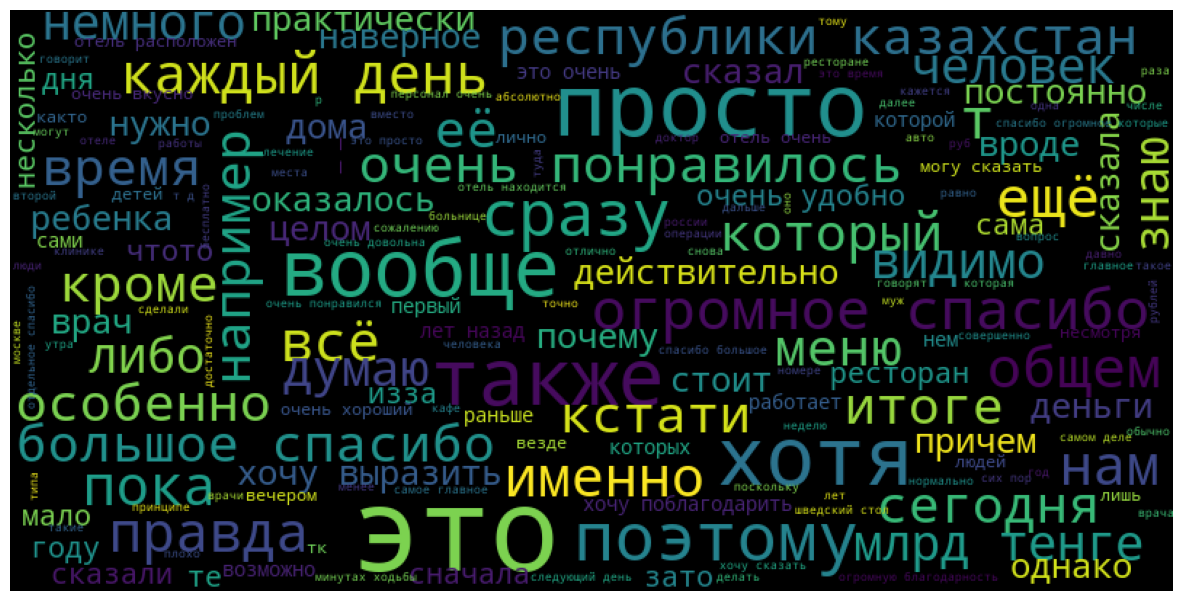

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40,
        scale=2,
        random_state=1
    ).generate(" ".join(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


show_wordcloud(train['lem'])

In [ ]:
train.to_csv('embs.csv', index=False)

## Мы решили взять разные модели, основанные на архитектуре трансформер, а также рекуррентные нейронные сети, чтобы дообучить каждую из них и посмотреть, действительно ли трансформер показывает себя лучше, а также выбрать лучшую

Первая модель - ruBERT, заточеннный под задачу классификации текста, который обучался на данных, схожих с нашими, поэтому можно не трогать слои и просто посмотреть score

In [ ]:
!pip list


In [8]:
!pip install --upgrade pip setuptools wheel
!pip install xformers

  Using cached xformers-0.0.25.tar.gz (4.1 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [248 lines of output]
      running bdist_wheel
      /Users/antontagiev/PycharmProjects/text_summarization_sirius/venv/lib/python3.11/site-packages/torch/utils/cpp_extension.py:500: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
        warnings.warn(msg.format('we could not find ninja.'))
      running build
      running build_py
      creating build
      creating build/lib.macosx-10.9-universal2-cpython-311
      creating build/lib.macosx-10.9-universal2-cpython-311/xformers
      copying xformers/_deprecation_warning.py -> build/lib.macosx-10.9-universal2-cpython-311/xformers
      copying xformers/attn_bias_utils.py -> build/lib.macosx-10.9-universal2-cpython-311/xformers
   

In [9]:
from transformers import pipeline

pipe = pipeline("text-classification", model="MonoHime/rubert-base-cased-sentiment-new")


Обрежем текст, чтобы умещаться в данное количество токенов

In [10]:
test['text'] = test['text'].apply(lambda text: text[:1024])

In [11]:
test['text']

0        Развода на деньги нет Наблюдаюсь в Лайфклиник ...
1        Отель выбрали потому что рядом со стадионом. О...
2        Вылечили Гноился с рождения глазик, в поликлин...
3        Хорошее расположение.С вокзала дошли пешком.Но...
4        Отличное месторасположение,прекрасный вид,особ...
                               ...                        
21093    Несколько лет назад муж останавливался в этом ...
21094    Спасли от боли После родов у меня появились бо...
21095    з ролика понятно одно - девушка- наблюдатель  ...
21096    Остались всем довольны, дружелюбный персонал, ...
21097    Спасибо огромное за сыночка Хочу выразить огро...
Name: text, Length: 21098, dtype: object

In [ ]:
# import razdel
# import re
#
#
# # Функция для токенизации текста с использованием библиотеки razdel
# def tokenize_text(text):
#     tokens = [token for token in razdel.tokenize(text)]
#     return tokens
#
#
# # Применяем токенизацию сначала к тексту, а затем к результатам первой токенизации
# test['refact_text'] = test['text'].apply(lambda tokens: ''.join(tokens))  # объединяем списки токенов обратно в текст
# test['refact_text'] = test['refact_text'].apply(tokenize_text)  # применяем токенизацию с использованием razdel


In [ ]:
# def extract_words(tokens):
#     words = [token.text for token in tokens if token.text.isalpha()]
#     return words
#
#
# test['refact_text'] = test['refact_text'].apply(extract_words)
# test['refact_text']

In [ ]:
import re

pattern = r'[^\w\s]|\d|http\S+'

# Применяем регулярное выражение ко всему столбцу 'Text'
test['text'] = test['text'].apply(lambda x: re.sub(pattern, '', x))
test['refact_text'] = test['text'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

In [ ]:
test['refact_text'] = test['refact_text'].apply(
    lambda tokens: [word.lower() for word in tokens if word.lower() not in stop_words and word != ''])

In [ ]:
test['refact_text']

In [ ]:
def predict_sentiment(text):
    result = pipe(text)[0]  # Получение результата анализа текста
    return result['label']  # Возвращение метки настроения


# Применение функции к каждой строке в столбце 'text'
test['sentiment'] = test['refact_text'].apply(predict_sentiment)

In [ ]:
test['sentiment']

In [ ]:
test['sentiment'] = test['sentiment'].str.replace('NEGATIVE', '2')
test['sentiment'] = test['sentiment'].str.replace('POSITIVE', '1')
test['sentiment'] = test['sentiment'].str.replace('NEUTRAL', '0')

In [ ]:
result = test.drop('text', axis=1)

Набранный F1-score на AllCups - 0.60

In [ ]:
result = result.drop('refact_text', axis=1)
result.to_csv('../outputs/from_pretrained2.csv', index=False)

Сохраним эту модельку как неплохой вариант и пойдем дальше

In [ ]:
import joblib

joblib.dump(pipe, '../models/pretrained_model.pkl')

#### Далее мы решили дообучить модель BERT для анализа тональности, потому что обычно она справляется с задачами классификации лучше, чем GPT

Код с дообучением находится в файле fine-tuning-bert.ipynb, обучить модель не получилось, поскольку это потребовало значительных ресурсов. Обучение шло на 4090 с 64 гигабайтами оперативной памяти, однако этого оказалось мало.

Выходом из сложившейся ситуации оказалась библиотека LightAutoML от сбера, на базе которой мы развернули уже новую модель параллельно строя ROC-кривую

Дальнейшее продолжение в файле 'Christian's automl.ipynb'